In [150]:
import numba
import heapq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import dataclasses
import timeit
import tqdm
import random
import pandas as pd
import joblib
import seaborn as sn
import itertools

# Добро пожаловать в мой ноутбук!!!

Сегодня мы бенчмаркаем A* с ограниченной ошибкой. Объяснения будут по ходу.

По сути, большая часть работы взята из первого ноутбука с бенчмарком A*, так что ничем новым я вас не удивлю.

In [151]:
SQRT2 = np.sqrt(2.0)

# Реализация A*

Реализация A* почти полностью скопирована, с тем изменением, что
теперь вместо того, чтобы принимать эвристику как параметр, она вызывает
функцию `heuristic`, а через параметр принимает ограничение на допустимую ошибку `w`.
Я все еще использую `numba` для ускорения кода.

На вход функция принимает булев массив проходима ли клетка,
начальная и конечная клетки, `w`, и булев параметр разрешается ли
перераскрытие состояний.

Конечно, в условии лабы написано, что перераскрытие делать не надо, но
у меня оно уже было сделано в 4 лабе, да и вообще любопытно посмотреть, что будет.
Как известно, Эйнштейн открыл теорию относительности не потому, что это было
написано в условии домашнего задания, так что... угадай что, README.md, ты снова проиграл!!!

Реализация все еще ограничена до 2D клеточных гридов, где каждая клетка либо проходима, либо непроходима.
Tiebreak захардкоден до максимального g-значения. Исследовать его не в моих планах.

In [152]:
Result = collections.namedtuple("Result", ["found", "g_grid", "closed", "came_from_compact", "stats"])

@numba.njit
def heuristic(a, b):
    dx = np.abs(float(a[0] - b[0]))
    dy = np.abs(float(a[1] - b[1]))
    return max(dx, dy) + (SQRT2 - 1.0) * min(dx, dy)

@numba.njit
def a_star(grid, start, end, w, reexpansion=False):
    opened = [(heuristic(start, end) * w, 0.0, 0.0, start)]
    closed = np.full_like(grid, False, dtype=np.bool)
    came_from_compact = np.full_like(grid, -1, dtype=np.int64)
    g_grid = np.full_like(grid, np.inf, dtype=np.float64)
    g_grid[start] = 0.0

    stats = {
        "opened": 0,
        "closed": 0,
        "expanded": 0,
        "reopened": 0,
    }

    while len(opened) > 0:
        _, _, gv, v = heapq.heappop(opened)
        if closed[v]:
            continue

        if v == end:
            return Result(
                found=True,
                g_grid=g_grid,
                closed=closed,
                came_from_compact=came_from_compact,
                stats=stats,
            )

        vx, vy = v
        for dv, cost in (
            ((0, 1), 1.0), ((1, 0), 1.0), ((0, -1), 1.0), ((-1, 0), 1.0),
            ((1, 1), SQRT2), ((1, -1), SQRT2), ((-1, 1), SQRT2), ((-1, -1), SQRT2)
        ):
            u = (v[0] + dv[0], v[1] + dv[1])
            ux, uy = u
            if not (0 <= ux < grid.shape[0] and 0 <= uy < grid.shape[1]):
                continue
            if grid[ux, uy] or grid[vx, uy] or grid[ux, vy]:
                continue

            gu = gv + cost

            # if not reexpansion and closed[u]:
            #     assert gu >= g_grid[u] - 1e-5, f"gu: {gu}, g_grid[u]: {g_grid[u]}"

            if gu < g_grid[u] and (reexpansion or not closed[u]):
                stats["opened"] += 1
                g_grid[u] = gu
                hu = heuristic(u, end) * w
                fu = gu + hu
                heapq.heappush(opened, (fu, -gu, gu, u))
                came_from_compact[u] = vx << 32 | vy
                if reexpansion and closed[u]:
                    closed[u] = False
                    stats["reopened"] += 1

            stats["expanded"] += 1

        closed[v] = True
        stats["closed"] += 1

    return Result(
        found=False,
        g_grid=g_grid,
        closed=closed,
        came_from_compact=came_from_compact,
        stats=stats,
    )


@numba.njit
def trace_path(start, end, came_from_compact):
    path = []
    v = end
    while v != start:
        path.append(v)
        assert came_from_compact[v] != -1
        v = (came_from_compact[v] >> 32, came_from_compact[v] & ((1 << 32) - 1))
    path.append(start)
    return path[::-1]


def a_star_and_trace(grid, start, end, w, reexpansion=False):
    result = a_star(grid, start, end, w, reexpansion)
    if not result.found:
        return np.inf, result.stats, None
    path = trace_path(start, end, result.came_from_compact)
    result.stats["path_length"] = len(path)
    return result.g_grid[end], result.stats, path

Давайте посмотрим на несколько примеров работы алгоритма на разных небольших сетках.

Отмечу, что на некоторых примерах заметно, как график g-значений выглядит негладко,
что связано с тем, что алгоритм не гарантирует оптимальность при ограниченной ошибке.

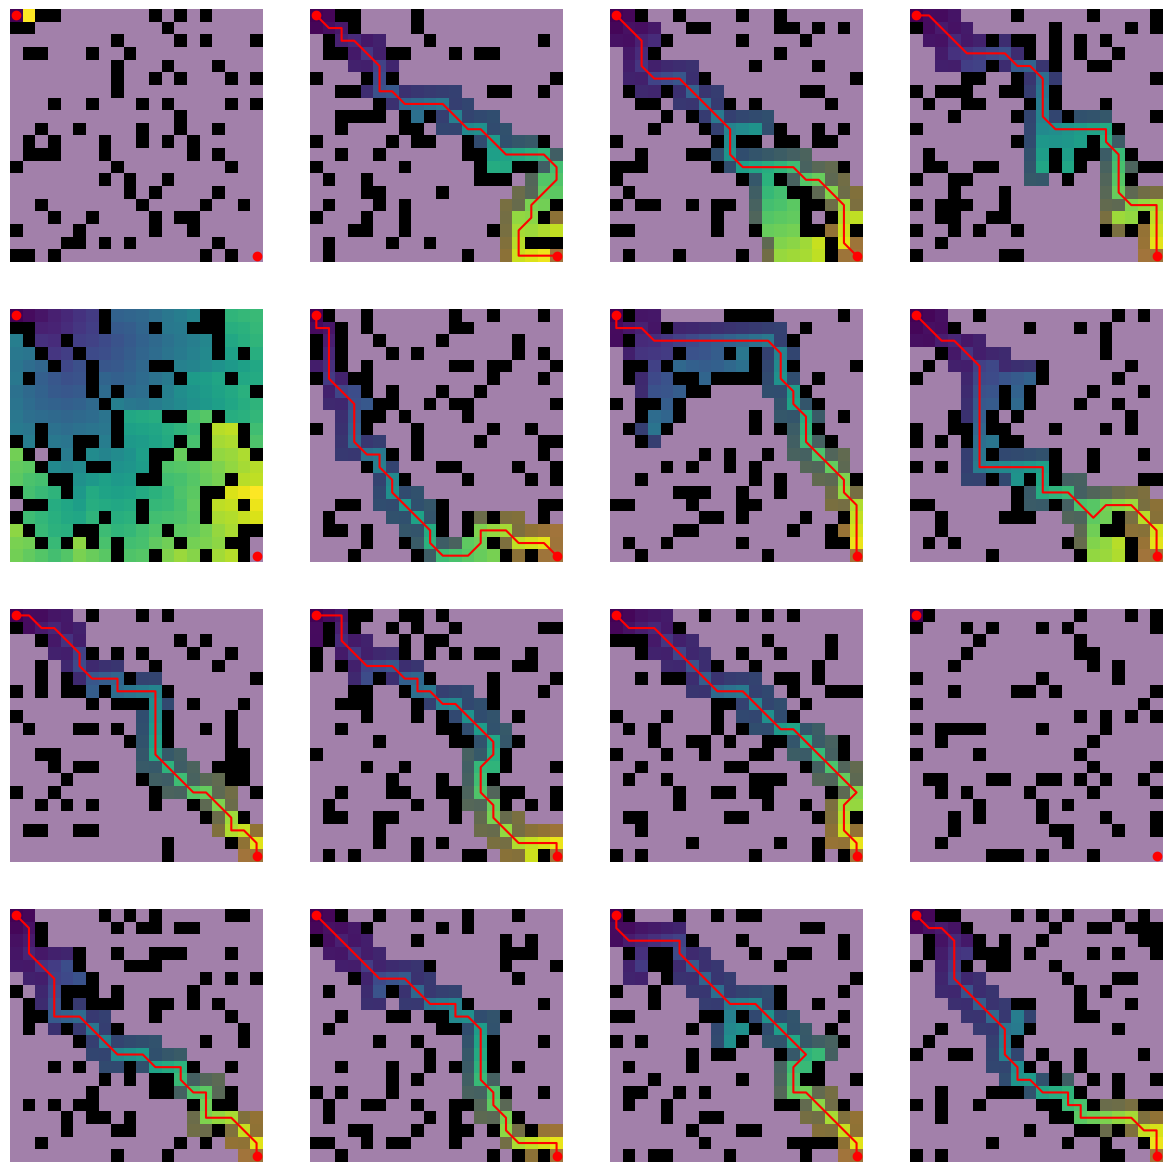

In [153]:
def visualize(grid, start, end, found, g_grid, closed, came_from, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.imshow(grid, cmap=mpl.colors.ListedColormap(['white', 'black']), alpha=grid.astype(np.float64))
    ax.imshow(g_grid, cmap='viridis', alpha=1.0)
    ax.imshow(np.ma.masked_where(~np.logical_and(~closed, ~grid), np.full_like(grid, 0)), alpha=0.5, vmin=0.0, vmax=1.0)

    ax.plot(start[1], start[0], 'ro')
    ax.plot(end[1], end[0], 'ro')

    if not found:
        return

    path = trace_path(start, end, came_from)
    path = np.array(path)
    ax.plot(path[:, 1], path[:, 0], 'r-')


def run_and_visualize(grid, start, end, heuristic, reexpansion=False, fig=None, ax=None):
    found, g_grid, closed, came_from, _ = a_star(grid, start, end, heuristic, reexpansion)
    visualize(grid, start, end, found, g_grid, closed, came_from, fig, ax)


fig, axs = plt.subplots(4, 4, figsize=(12, 12))
fig.tight_layout(pad=0.0)
rng = np.random.default_rng(0)
for i in range(4):
    for j in range(4):
        N = 20
        grid = rng.random((N, N)) < 0.2
        grid[0, 0] = 0
        grid[N - 1, N - 1] = 0
        run_and_visualize(grid, (0, 0), (N - 1, N - 1), 2.0, fig=fig, ax=axs[i, j])

# Выбор задач

Задачи выбираются ровно также как и раньше. Этот код необходим для скачивания задач, про выбор написано чуть-чуть ниже.

Единственное содержательное различие: я починил баг, из-за которого неправильно проставлялись `problem_id`.

In [154]:
from bs4 import BeautifulSoup
import requests
import re
import urllib
from pathlib import Path
import zipfile

PROBLEM_ROOT = Path("problems")

if not PROBLEM_ROOT.exists():
    PROBLEM_ROOT.mkdir(exist_ok=True)
    session = requests.Session()

    MOVINGAI_PAGE_URL = urllib.parse.urlparse("https://movingai.com/benchmarks/grids.html")

    response = session.get(MOVINGAI_PAGE_URL.geturl())
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    maps = soup.find_all("a", href=re.compile("-map.zip$"))
    scens = soup.find_all("a", href=re.compile("-scen.zip$"))

    for link in maps + scens:
        rel_url = link["href"]
        url = urllib.parse.urljoin(MOVINGAI_PAGE_URL.geturl(), rel_url)
        print(url)
        zip_path = PROBLEM_ROOT / rel_url.split("/")[-1]
        if not zip_path.exists():
            response = session.get(url)
            response.raise_for_status()
            zip_path.write_bytes(response.content)
        archive = zipfile.ZipFile(zip_path)

        directory = PROBLEM_ROOT / "-".join(zip_path.stem.split("-")[:-1])
        directory.mkdir(exist_ok=True)
        for file in archive.namelist():
            file_path = Path(file)
            map_path = directory / file_path.name
            with archive.open(file) as f:
                map_path.write_bytes(f.read())

In [155]:
@dataclasses.dataclass
class Problem:
    category: str
    map_name: str
    problem_id: int
    grid: np.ndarray
    start: tuple[int, int]
    end: tuple[int, int]
    expected_answer: float


PROBLEMS = {}
problem_id = 0


for category in PROBLEM_ROOT.iterdir():
    if not category.is_dir():
        continue
    category_name = category.name
    maps = {}
    skipped = set()
    for map_file in category.glob("*.map"):
        map_name = map_file.name

        lines = iter(map_file.read_text().splitlines())

        if next(lines) != "type octile":
            print(f"Skipping {category_name}/{map_name} because it is not octile")
            skipped.add(map_name)
            continue 

        height = int(next(lines).removeprefix("height "))
        width = int(next(lines).removeprefix("width "))
        assert next(lines) == "map"

        grid = np.empty((width, height), dtype=np.bool)
        ok = True

        for y, line in enumerate(lines):
            for x, char in enumerate(line):
                if char in ('.', 'G'):
                    grid[x, y] = False
                elif char in ('@', 'O', 'T'):
                    grid[x, y] = True
                else:
                    ok = False
                    break
            if not ok:
                break

        if not ok:
            print(f"Skipping {category_name}/{map_name} because of unsupported tile kind: {char}")
            skipped.add(map_name)
            continue

        maps[map_name] = grid

    for scen_file in category.glob("*.map.scen"):
        scen = iter(scen_file.read_text().splitlines())

        assert next(scen) == "version 1"

        for line in scen:
            bucket, map_name, _, _, start_x, start_y, end_x, end_y, expected_answer = line.split()
            if map_name in skipped:
                continue

            PROBLEMS.setdefault(category_name, {}).setdefault(map_name, []).append(Problem(
                category=category_name,
                map_name=map_name,
                problem_id=problem_id,
                grid=maps[map_name],
                start=(int(start_x), int(start_y)),
                end=(int(end_x), int(end_y)),
                expected_answer=float(expected_answer),
            ))

            problem_id += 1

print(f"Loaded {sum(len(v) for v in PROBLEMS.values())} maps in {len(PROBLEMS)} categories")


Skipping weighted/Map1.map because of unsupported tile kind: C
Skipping weighted/Map2.map because of unsupported tile kind: C
Skipping weighted/Map14.map because of unsupported tile kind: B
Skipping weighted/Map11.map because of unsupported tile kind: B
Skipping weighted/Map12.map because of unsupported tile kind: B
Skipping weighted/Map3.map because of unsupported tile kind: C
Skipping weighted/Map16.map because of unsupported tile kind: B
Skipping weighted/Map6.map because of unsupported tile kind: B
Skipping weighted/Map20.map because of unsupported tile kind: B
Skipping weighted/Map18.map because of unsupported tile kind: B
Skipping weighted/Map13.map because of unsupported tile kind: B
Skipping weighted/Map4.map because of unsupported tile kind: B
Skipping weighted/Map9.map because of unsupported tile kind: B
Skipping weighted/Map8.map because of unsupported tile kind: B
Skipping weighted/Map17.map because of unsupported tile kind: B
Skipping weighted/Map7.map because of unsupport

Я вручную выбрал 5 совершенно непохожих
друг на друга категорий, а затем подбирал сид рандома до тех пор,
пока мне не понравятся 3 случайные карты из каждой категории.

Случайный выбор задач позволяет судить о всех задачах в общем, так как
выборочное распределение будет неплохо повторять истинное.

In [156]:
selected_categories = ["maze", "random", "street", "sc1", "bgmaps"]
NUM_MAPS = 3
NUM_PROBLEMS = 100

rng = np.random.default_rng(5)

def choose_problems(problems: dict[str, list[Problem]], rng) -> dict[str, list[Problem]]:
    possible_maps = [map_name for map_name in sorted(problems.keys()) if len(problems[map_name]) >= NUM_PROBLEMS]
    random_maps = rng.choice(possible_maps, NUM_MAPS, replace=False)
    return {
        map_name: rng.choice(problems[map_name], NUM_PROBLEMS, replace=False)
        for map_name in random_maps
    }

CHOSEN_PROBLEMS = {
    category: choose_problems(problems, rng)
    for category, problems in sorted(PROBLEMS.items(), key=lambda x: x[0])
    if category in selected_categories
}

Здесь можно посмотреть на эти карты визуально. Видно, что карты сильно отличаются
топологически, что делает их хорошей выборкой для бенчмаркинга.

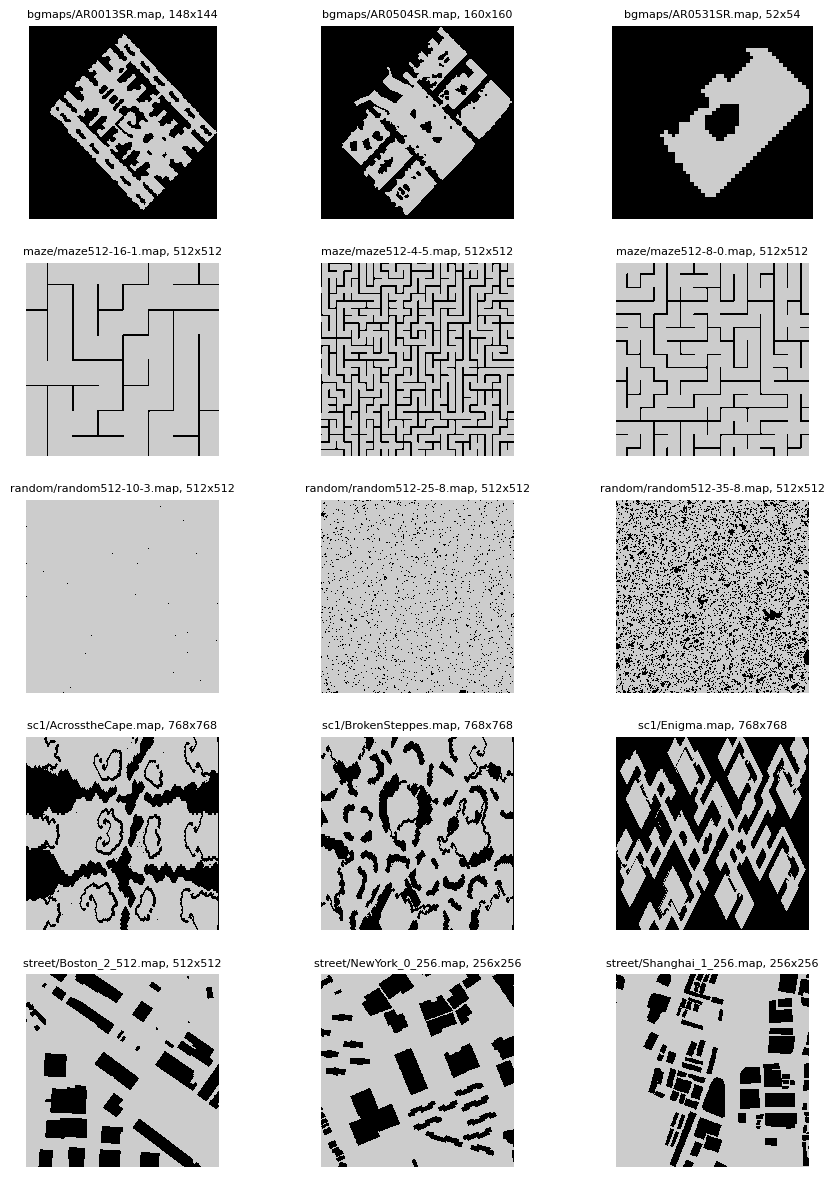

In [157]:
fig, axs = plt.subplots(len(selected_categories), NUM_MAPS, figsize=(9, 12))
fig.tight_layout()

for i, (category, category_problems) in enumerate(sorted(CHOSEN_PROBLEMS.items(), key=lambda x: x[0])):
    for j, (map_, map_problems) in enumerate(sorted(category_problems.items(), key=lambda x: x[0])):
        axs[i, j].axis('off')
        grid = map_problems[0].grid
        if category == "maze":
            grid = grid[20:150, 20:150]
        axs[i, j].imshow(grid, cmap=mpl.colors.ListedColormap(['0.8', 'black']))
        shape = map_problems[0].grid.shape
        axs[i, j].set_title(f"{category}/{map_}, {shape[0]}x{shape[1]}", fontsize=8)

# Бенчмаркинг

Здесь мы измеряем время работы, ничего нового.

Каждая задача запускается `number + 2` раза.

Из первого запуска мы узнаем статистику алгоритма.

Второй используется как setup для `timeit`, это чтобы убедиться,
что все функции скомпилировались к моменту запуска измерений
(у `timeit` есть всякие особенности среды, в которой он исполняет модули).

Затем алгоритм запускается `number` раз, и в статистику записывается среднее время работы.


In [158]:
def benchmark_one(problem: Problem, w, reexpansion=False):
    f = lambda: a_star_and_trace(problem.grid, problem.start, problem.end, w, reexpansion)
    dist, stats, _ = f()
    stats = dict(stats)
    stats["dist"] = dist
    stats["expected_dist"] = problem.expected_answer
    stats["correct"] = np.allclose(dist, problem.expected_answer)
    number = 5
    time = timeit.timeit(f, setup=f, number=number, globals=globals()) / number
    stats["time"] = time
    return stats

Наконец, само измерение. Для большего ускорения я использую `joblib`,
чтобы распараллелить бенчмаркинг на все ядра.

Отмечу небольшое изменение: теперь задачи перемешиваются перед бенчмаркингом,
чтобы немного избавится от эффектов связанных с нестабильностью производительности
процессора.

In [159]:
def run_one(problem, w, reexpansion):
    stats = benchmark_one(problem, w, reexpansion)
    return {
        "category": problem.category,
        "map": problem.map_name,
        "problem_id": problem.problem_id,
        "w": w,
        "reexpansion": reexpansion,
        **stats,
    }

args = []
for category, category_problems in CHOSEN_PROBLEMS.items():
    for map, map_problems in category_problems.items():
        for problem in map_problems:
            for w, reexpansion in itertools.product([1.0, 1.05, 1.1, 1.2, 1.5, 2.0, 3.0, 5.0, 10.0, 100.0], [False, True]):
                args.append((problem, w, reexpansion))


jobs = [joblib.delayed(run_one)(*arg) for arg in args]
random.seed(0)
random.shuffle(jobs)

if not Path("stats.csv").exists():
    STATS = joblib.Parallel(n_jobs=-1, verbose=0)(tqdm.tqdm(jobs))
    STATS = pd.DataFrame(STATS)
    STATS.to_csv("stats.csv", index=False)

In [160]:
STATS = pd.read_csv("stats.csv")

# Анализ

Начнем с того, что посмотрим на графики того, сколько мы выигрываем по времени,
проигрывая в оптимальности найденного пути.

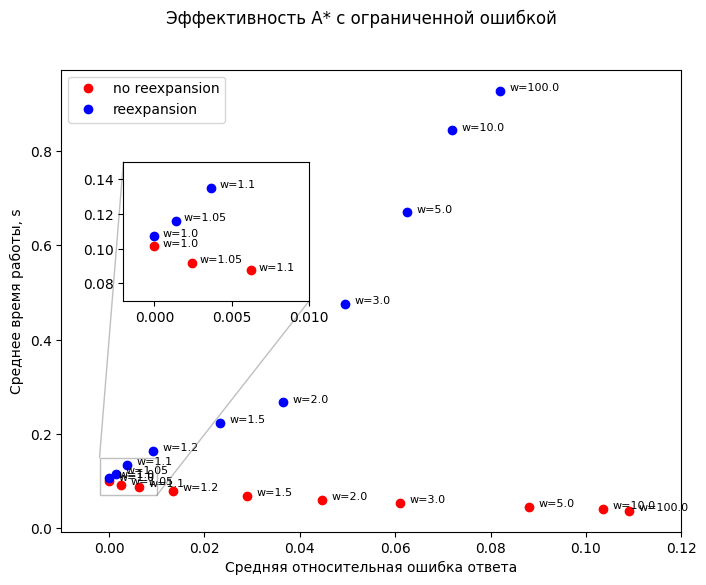

In [161]:
Ws = STATS.w.unique()

fig, ax = plt.subplots(figsize=(8, 6))

inset = ax.inset_axes([0.1, 0.5, 0.3, 0.3], xlim=(-0.002, 0.01), ylim=(0.07, 0.15))
ax.indicate_inset_zoom(inset)
ax.set_xlim(-0.01, 0.12)

for i, w in enumerate(Ws):
    for reexpansion in [False, True]:
        stats = STATS[(STATS.w == w) & (STATS.reexpansion == reexpansion)]
        time = stats.time.mean()
        ans_err = (stats.dist / stats.expected_dist).mean() - 1
        point, = ax.plot(ans_err, time, 'o', c='b' if reexpansion else 'r')
        if i == 0:
            point.set_label("reexpansion" if reexpansion else "no reexpansion")
        ax.text(ans_err + 0.002, time, f"w={w}", fontsize=8)
        inset.plot(ans_err, time, 'o', c='b' if reexpansion else 'r')
        inset.text(ans_err + 0.0005, time, f"w={w}", fontsize=8, clip_on=True)

fig.suptitle("Эффективность A* с ограниченной ошибкой")
ax.set_xlabel("Средняя относительная ошибка ответа")
ax.set_ylabel("Среднее время работы, s")
ax.legend()

Ок, по графику совершенно очевидно, что перераскрытие было большой ошибкой,
так как оно лишь замедляет алгоритм, заставляя перераскрывать вершины снова и снова.

Поэтому давайте выбросим все эксперименты с перераскрытим, и продолжим без них.

К сожалению, теорию относительности мы сегодня не открыли.

In [162]:
df = STATS.drop(STATS[STATS.reexpansion].index)
df.head()

,category,map,problem_id,w,reexpansion,opened,closed,expanded,reopened,path_length,dist,expected_dist,correct,time
1,sc1,AcrosstheCape.map,1639034,10.00,False,49586,19005,146542,0,744,954.248917,784.577777,False,0.047472
2,maze,maze512-4-5.map,891646,5.00,False,16327,10073,65526,0,674,764.541197,716.014285,False,0.023738
3,maze,maze512-8-0.map,1055932,3.00,False,244069,134586,976296,0,1926,2208.322077,2138.900720,False,0.282236
4,bgmaps,AR0531SR.map,23324,1.05,False,55,11,87,0,12,14.727922,14.727922,True,0.000056
5,random,random512-35-8.map,1359479,2.00,False,2841,2168,8420,0,487,529.078210,446.308658,False,0.004349


Посмотрим на тот же самый график, но теперь на его интересную часть.

Заодно посмотрим другую характеристику --- количество раскрытий, --- которое,
как известно, тесно коррелирует со временем.

Text(0, 0.5, 'Среднее количество раскрытых вершин')

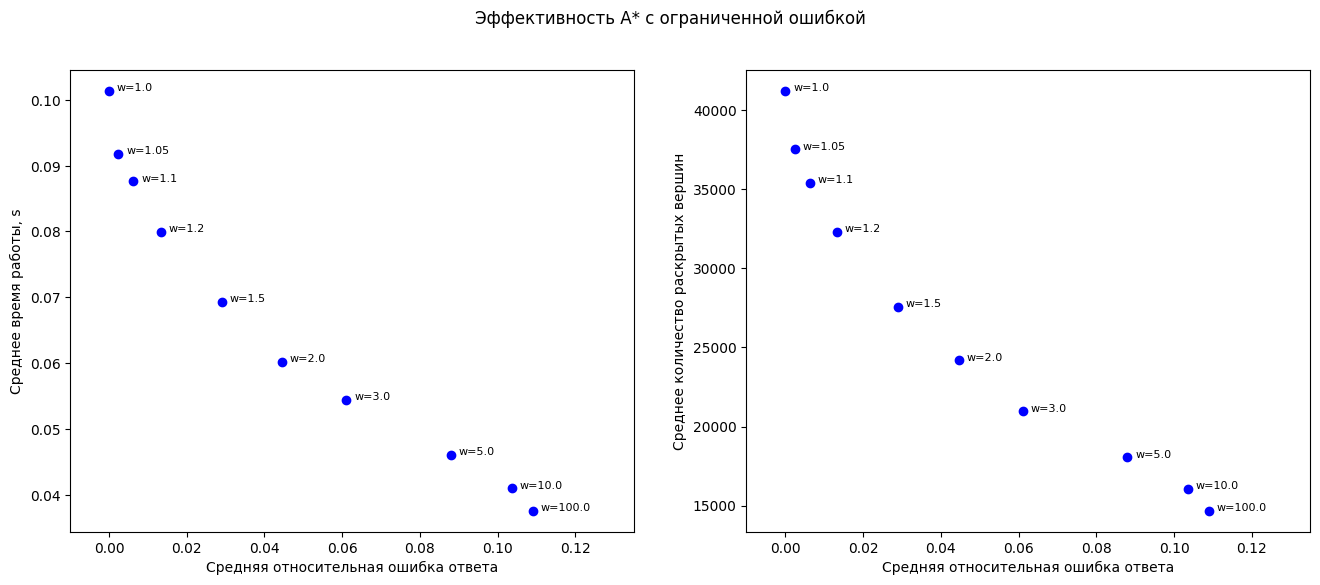

In [168]:
fig, (axt, axo) = plt.subplots(1, 2, figsize=(16, 6))
axt.set_xlim(0.99 - 1, 0.135)
axo.set_xlim(0.99 - 1, 0.135)

for i, w in enumerate(Ws):
        stats = df[df.w == w]
        time = stats.time.mean()
        ans_err = (stats.dist / stats.expected_dist).mean() - 1
        axt.plot(ans_err, time, 'o', c='b')
        axt.text(ans_err + 0.002, time, f"w={w}", fontsize=8)
        closed = stats.closed.mean()
        axo.plot(ans_err, closed, 'o', c='b')
        axo.text(ans_err + 0.002, closed, f"w={w}", fontsize=8)

fig.suptitle("Эффективность A* с ограниченной ошибкой")
axt.set_xlabel("Средняя относительная ошибка ответа")
axt.set_ylabel("Среднее время работы, s")
axo.set_xlabel("Средняя относительная ошибка ответа")
axo.set_ylabel("Среднее количество раскрытых вершин")

Так как графики получились очень похожими, я буду в основном смотреть на количество
раскрытий, так как оно более наглядно и детерминировано.

![they are the same picture](meme.jpg)

Можно сделать вывод, что в целом допуская ошибку можно добиться очень хорошего прироста
производительности за счет довольно небольшой потери качества,
и на практике оказывается, что потеря качества гораздо меньше теоретической оценки.

Например, устанавливая `w=2` можно получить двукратный прирост производительности, за счет увеличения
длины найденного пути в среднем на 5%.

Теперь посмотрим на то, как на конкретных задачах ограниченная ошибка дает выигрыш.

Я ранжировал задачи по количество раскрытий обычного A*, и
нарисовал scatter-plot-ы для всех исследованных значений `w`.

Я выбросил довольно много первых задач, чтобы не смотреть на простые задачи.

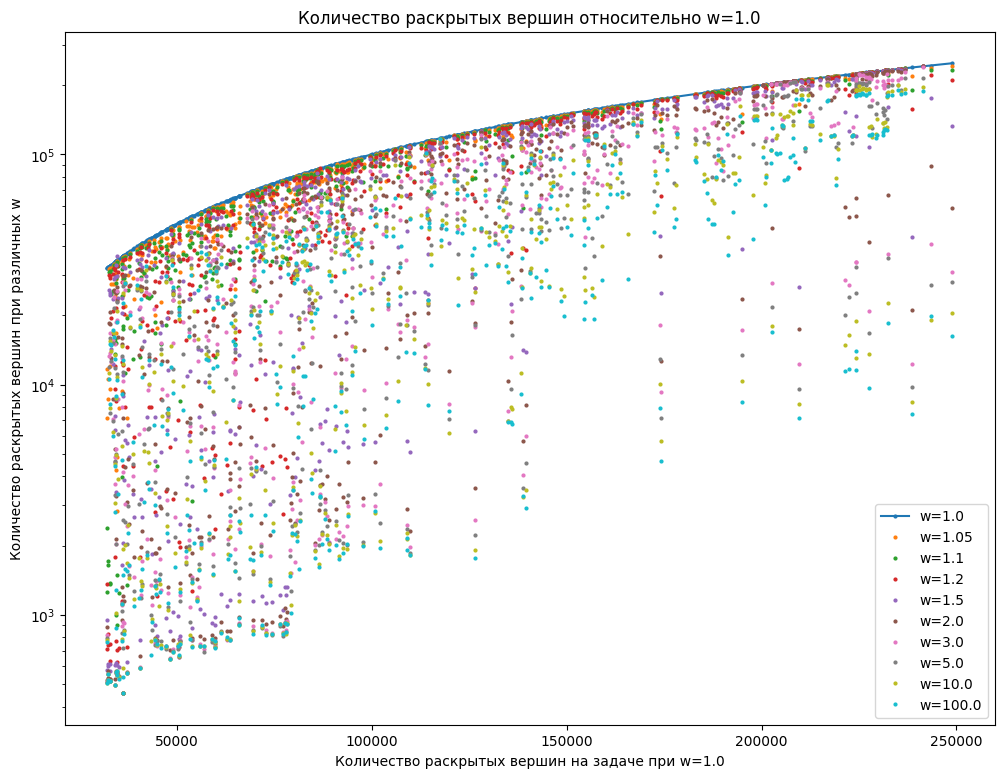

In [164]:
fig, ax = plt.subplots(figsize=(12, 9))

sorted_problem_ids = df[df.w == 1.0].sort_values("closed").problem_id
inv_problem_ids = {problem_id: i for i, problem_id in enumerate(sorted_problem_ids)}
stats = {}
for row in df.itertuples():
    if row.w not in stats:
        stats[row.w] = [None] * len(sorted_problem_ids)
    stats[row.w][inv_problem_ids[row.problem_id]] = row

SKIP = 1000
num_closed_w1 = np.array([row.closed for row in stats[1.0]])
for w in sorted(stats.keys()):
    stat = stats[w]
    num_closed = np.array([row.closed for row in stat])
    ax.plot(num_closed_w1[SKIP:], num_closed[SKIP:], 'o' if w != 1.0 else 'o-', label=f"w={w}", markersize=2)

ax.title.set_text("Количество раскрытых вершин относительно w=1.0")
ax.set_xlabel("Количество раскрытых вершин на задаче при w=1.0")
ax.set_ylabel("Количество раскрытых вершин при различных w")
ax.set_yscale('log')
ax.legend()

Хотя по сути график представляет из себя импрессионистскую картину, в нем можно
отметить несколько трендов.

Во-первых, более менее видно, что чем больше `w`, тем больше выигрыш по количеству раскрытий.
Это особенно очевидно, если смотреть на отдельные столбцы.

Однако зависимость сильно не линейная, и можно наблюдать несколько сильных выбросов даже для небольших
`w`.

Отмечу также несколько точек, которые лежат выше графика `w = 1`. Их присутствие
предсказуемо: иногда эвристика может завести не туда.

Посмотрим на что-то более читаемое, пожертвовав структурой задач. Посмотрим на посортированные значения количества раскрытий по всем задачам для каждого значения `w`, не обращая внимания на то, что это за задачи. 

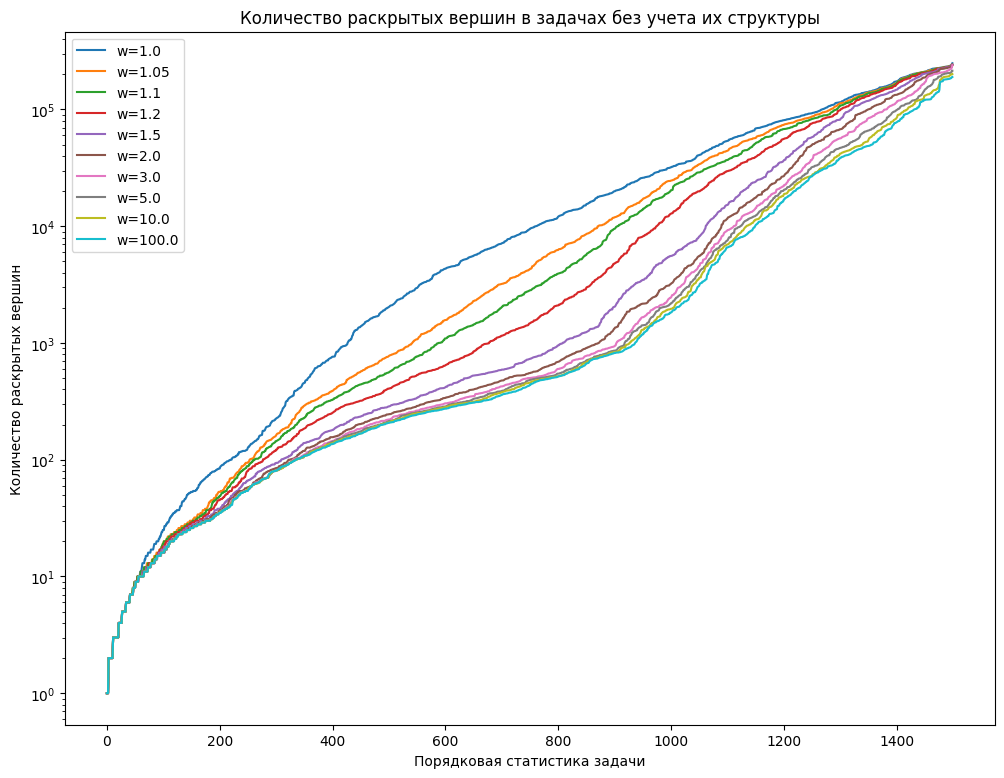

In [165]:
fig, ax = plt.subplots(figsize=(12, 9))

for w in sorted(stats.keys()):
    stat = stats[w]
    num_closed = np.array([row.closed for row in stat])
    num_closed.sort()
    ax.plot(num_closed, label=f"w={w}", markersize=2)

ax.legend()
ax.title.set_text("Количество раскрытых вершин в задачах без учета их структуры")
ax.set_xlabel("Порядковая статистика задачи")
ax.set_ylabel("Количество раскрытых вершин")
ax.set_yscale('log')

Можно заметить, что большее увеличение `w` дает менее заметные результаты (diminishing returns короче),
так как графики соответствующие большим `w` сильно жмутся друг с другу.

Наконец, посмотрим как структура задач влияет на эффективность метода. Посмотрим на тот же график эффективности из начала анализа,
но для каждой карты по отдельности.

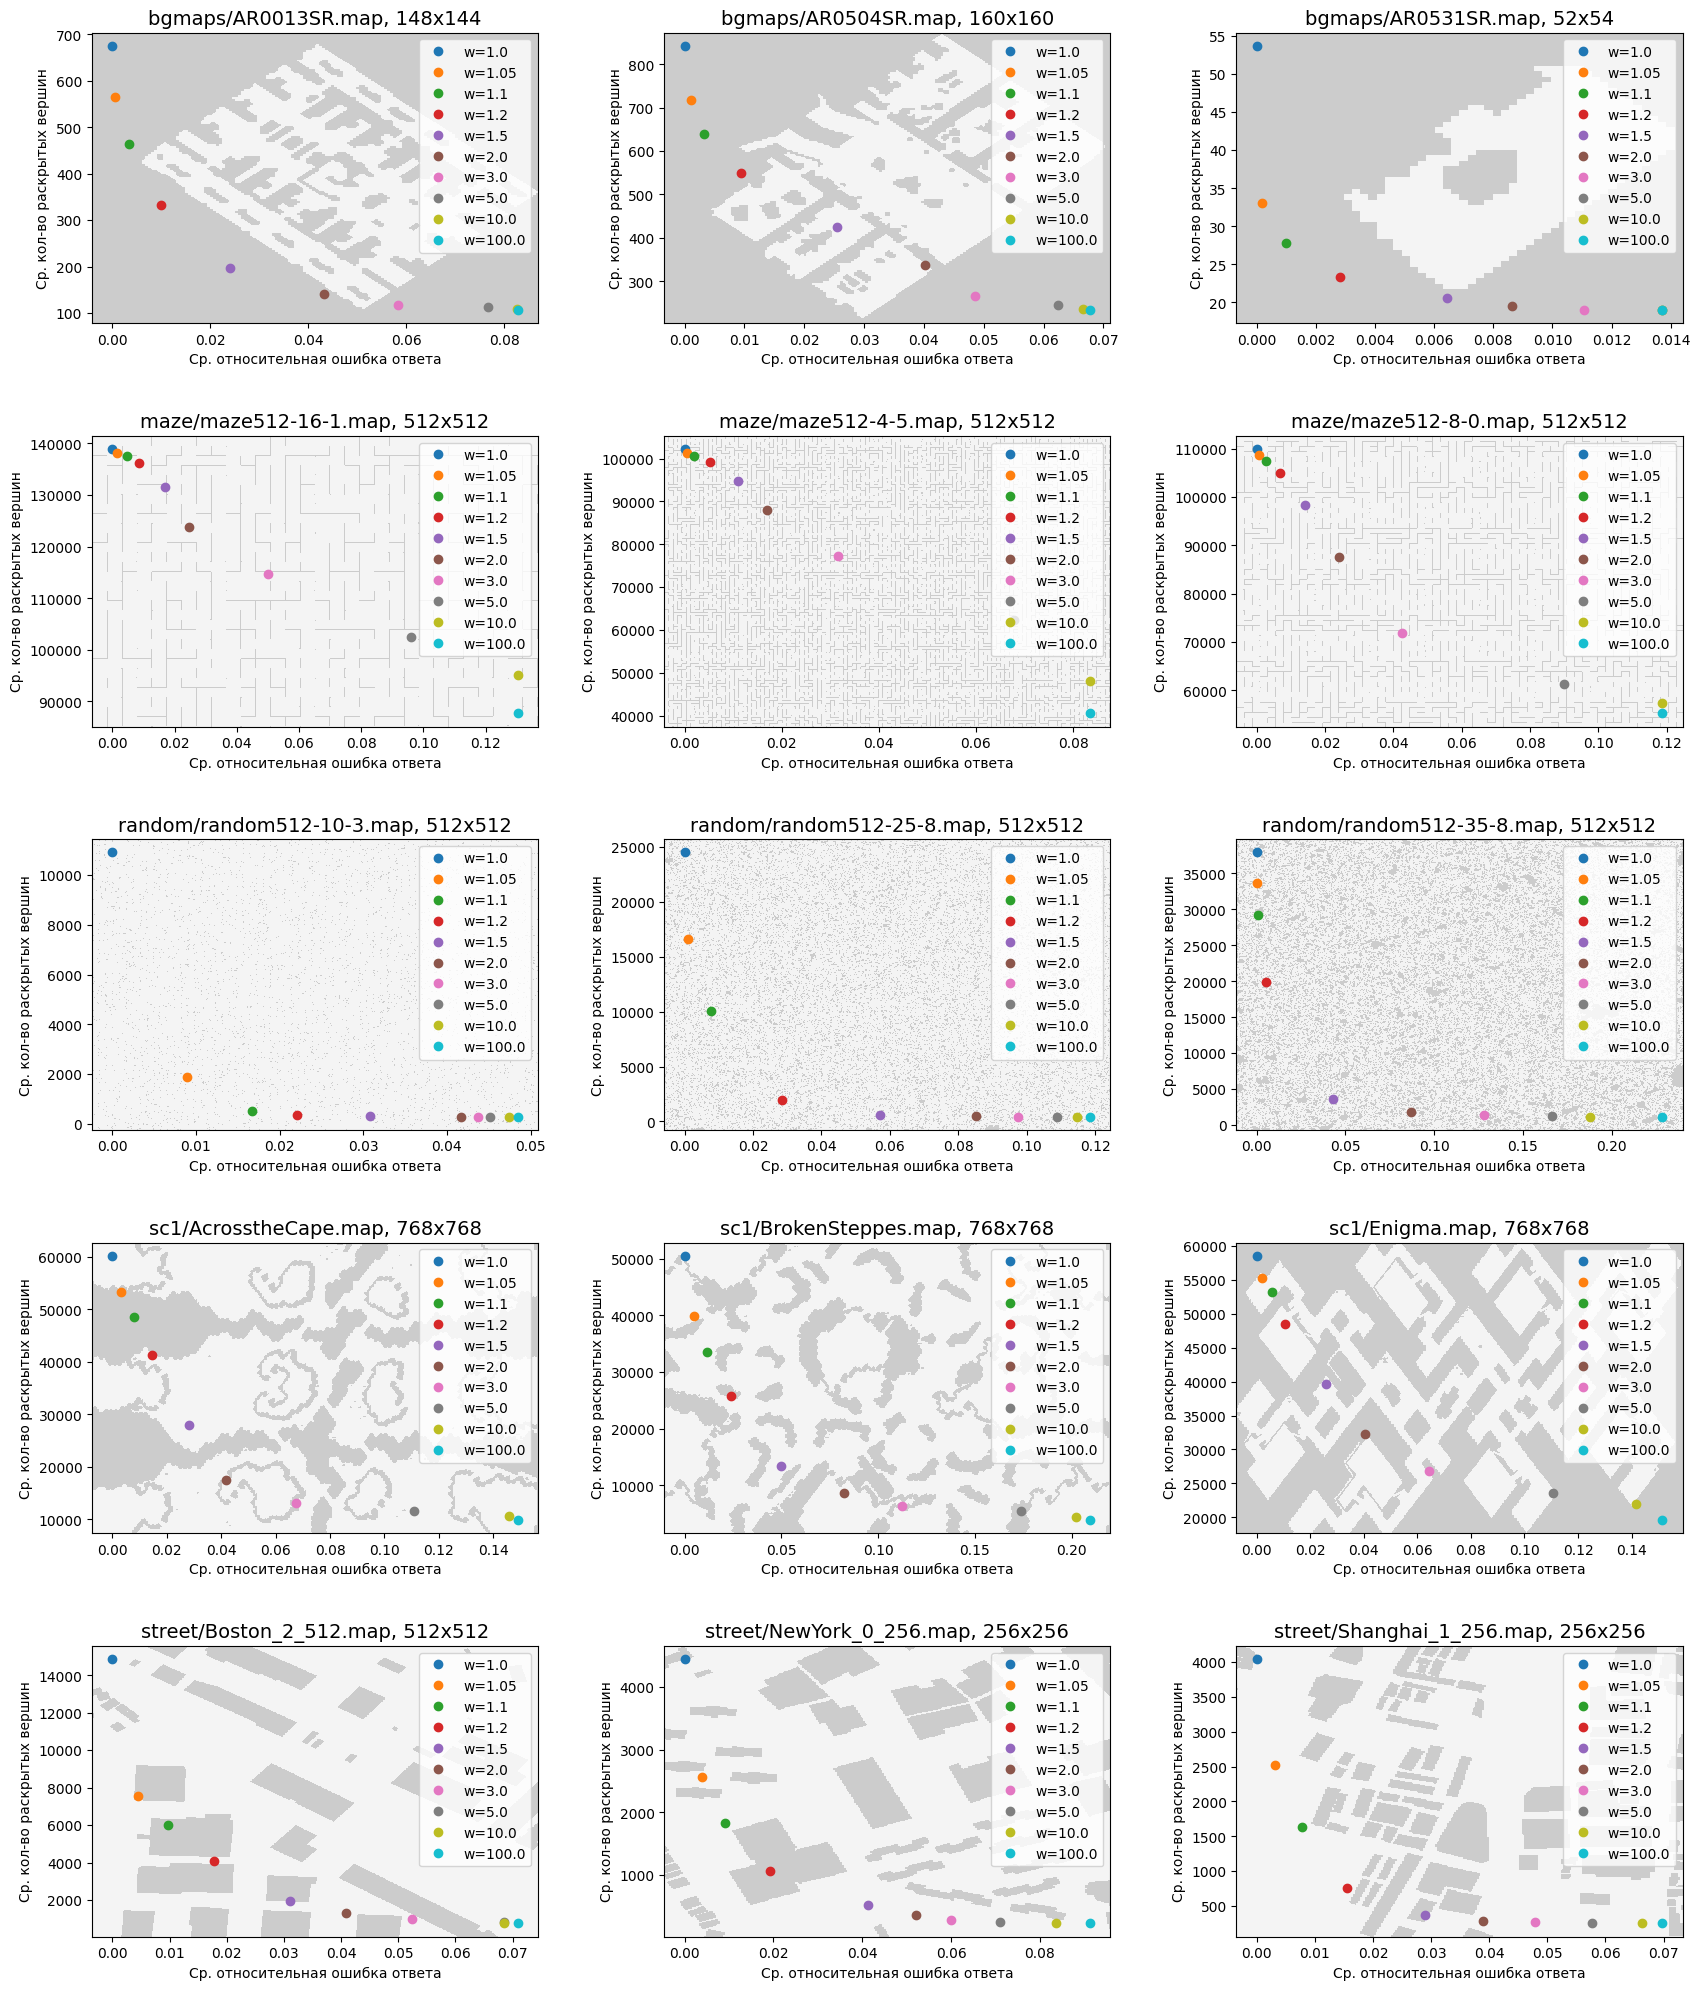

In [166]:
fig, axs = plt.subplots(len(selected_categories), NUM_MAPS, figsize=(18, 21))
fig.tight_layout(pad=6.0)

for i, (category, category_problems) in enumerate(sorted(CHOSEN_PROBLEMS.items(), key=lambda x: x[0])):
    for j, (map_, map_problems) in enumerate(sorted(category_problems.items(), key=lambda x: x[0])):
        data = STATS[(STATS.category == str(category)) & (STATS["map"] == str(map_))]

        ax = axs[i, j]
        shape = map_problems[0].grid.shape
        ax.set_title(f"{category}/{map_}, {shape[0]}x{shape[1]}", fontsize=14)

        img = ax.inset_axes([0.0, 0.0, 1.0, 1.0], zorder=-1)
        img.axis('off')
        img.imshow(map_problems[0].grid, cmap=mpl.colors.ListedColormap(['0.8', 'black']), aspect="auto", alpha=0.2)

        for w in sorted(Ws):
            stats = df[(df.w == w) & (df.category == str(category)) & (df["map"] == str(map_))]
            closed = stats.closed.mean()
            ans_err = (stats.dist / stats.expected_dist).mean() - 1
            ax.plot(ans_err, closed, 'o', label=f"w={w}")
        ax.set_xlabel("Ср. относительная ошибка ответа")
        ax.set_ylabel("Ср. кол-во раскрытых вершин")
        ax.legend()


Самый важный вывод, который можно сделать от сюда, это то, что на картах с относительно простой топологией,
на которых меньше препятствий и эвристика лучше оценивает h*,
даже небольше w дает хороший прирост в скорости, и не сильно увеличивает ошибку;
в то время как на лабиринтах trade-off скорости и ошибки почти линейный.

Попробовать объяснить это можно так:
на простых картах эвристика вообще помогает, потому что хорошо направляет поиск
в нужном направлении. Проблема, которая решается допусканием ошибки, это случаи, когда
эвристика привела нас в тупик. Она заставляет алгоритм все равно верить в нее,
и более агрессивно искать обход тупика, вместо того, чтобы исследовать другие пути.

На простых картах этот подход отлично работает: там обычно мы действительно просто
упираемся в несколько препятствий, которые мы без проблем обходим, но
в лабиринтах все уже не так просто. Да, мы все равно работаем лучше в среднем,
потому что мы не слепые и эвристика хоть как-то нас направляет, но от того, что
она направляет лучше выигрыш совсем не такой большой.

И последнее: распределения ошибки ответа при разных значениях `w`.

Заметно, что ошибка действительно увеличивается с увеличением `w`, но
не так сильно, как можно было бы ожидать.

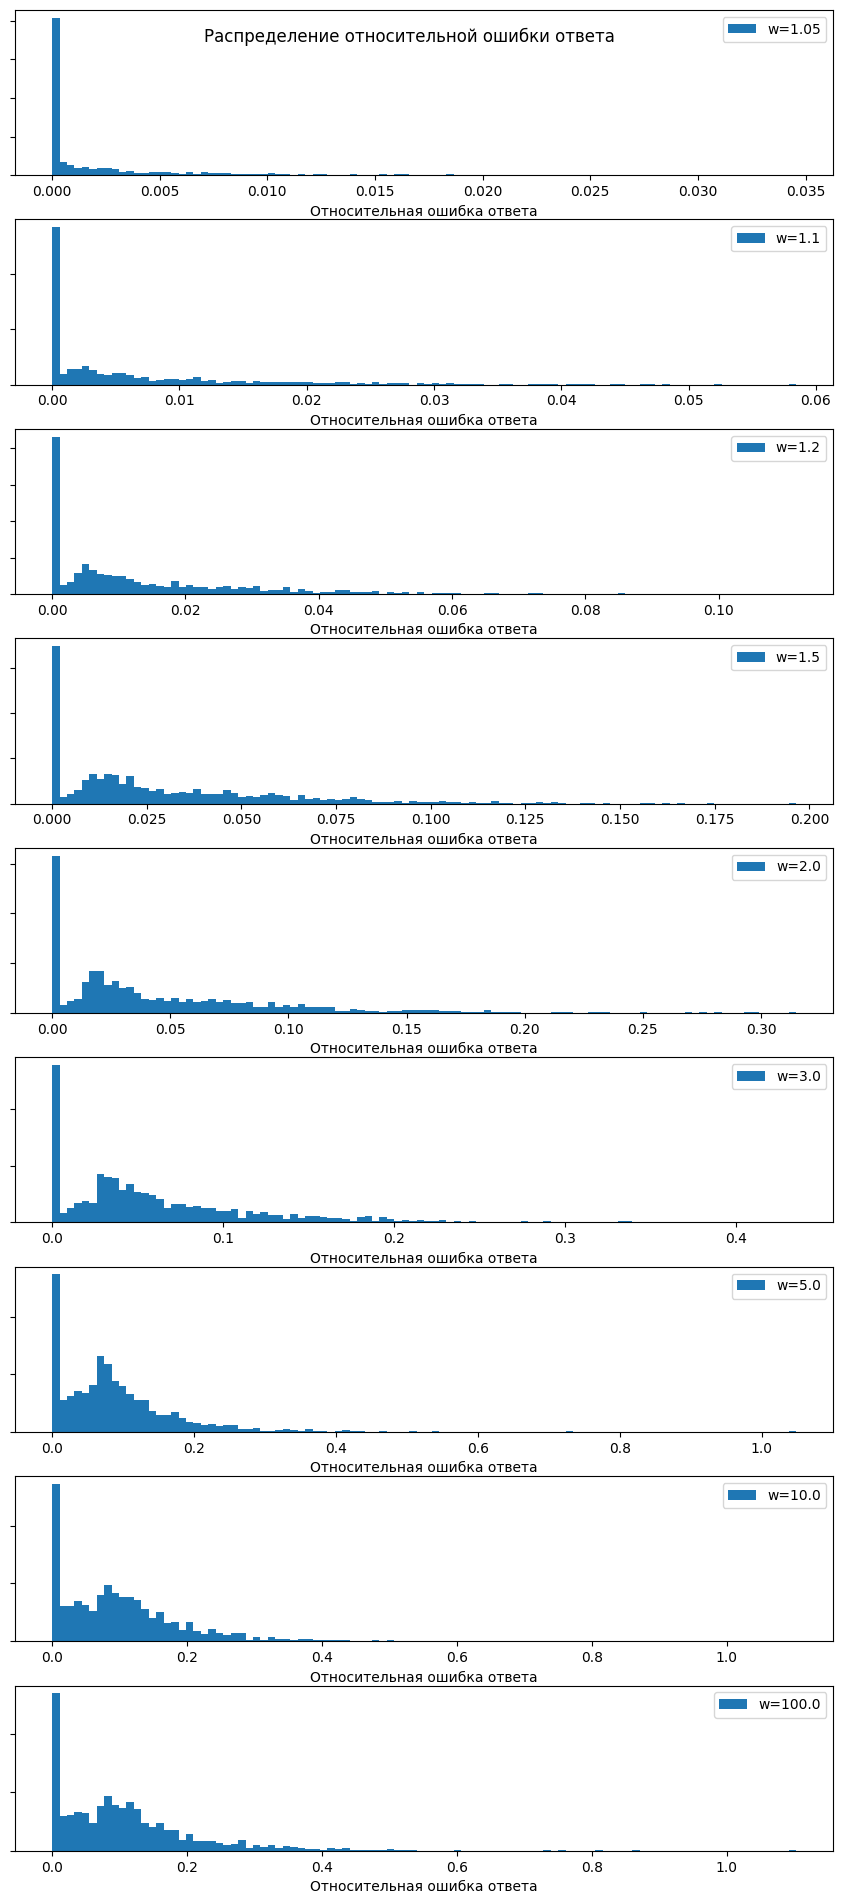

In [167]:
fig, axs = plt.subplots(len(Ws) - 1, figsize=(9, 2 * len(Ws) - 1))
fig.tight_layout()
fig.suptitle(f"Распределение относительной ошибки ответа")

for i, w in enumerate(sorted(Ws)[1:]):
    ax = axs[i]
    data = df[df.w == w]
    error = (data.dist / data.expected_dist - 1)
    ax.hist(error, bins=100, label=f"w={w}")
    ax.legend()
    ax.set_yticklabels([])
    ax.set_xlabel("Относительная ошибка ответа")

# Выводы

Мы проанализировали работу A* с ограниченной ошибкой на разных задачах,
и пришли к выводу, что это действительно хороший метод для ускорения поиска пути,
который как правильно не так сильно увеличивает ошибку, как можно было бы ожидать.

Мы поняли, что абсолютно никакого смысла нет в перераскрытии вершин, так как
это только замедляет алгоритм.

Мы поняли, что увеличение `w` довольно стабильно увеличивает производительность,
хоть и не всегда, и что особого смысла в огромном `w` нет, так как выигрыш
от него сильно уменьшается.

Мы поняли, что на простых картах допускание ошибки дает больший прирост в скорости,
чем на сложных.

Мы поняли, что ошибка действительно увеличивается с увеличением `w`, но не так сильно,
как можно было бы ожидать, и точно меньше теоретической оценки.